# Import Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sns.set()

# Import dataset

In [2]:
train = pd.read_csv(r'C:\Users\Mahira\Downloads\train_v9rqX0R.csv')
test = pd.read_csv(r'C:\Users\Mahira\Downloads\test_AbJTz2l.csv')
train['source']='train'
test['source']='test'
#train[train['Item_Identifier'] == 'FDX07']

In [3]:
#dataset_no_null = dataset.dropna()

In [4]:
data = pd.concat([train, test], ignore_index=True)

In [5]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [6]:
data.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

In [7]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
#Print frequency of categories
for col in categorical_columns:
    print ('\nFrequency of Categories for varible' + col)
    print (data[col].value_counts())


Frequency of Categories for varibleItem_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varibleItem_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varibleOutlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Frequency of Categories for varibleOutlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequ

# Data Cleaning 

In [8]:
#Determine the average weight per item:
#data['Item_Weight'] = data['Item_Weight'].replace(np.nan, 0)
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

#Get a boolean variable specifying missing Item_Weight values
miss_bool = (data['Item_Weight'] == 0)
#miss_bool = data['Item_Weight'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('Original #missing: ')
print(sum(data['Item_Weight'].isnull()))

Original #missing: 
2439


In [9]:
item_avg_weight

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


In [10]:
#data['Item_Weight'] = pd.to_numeric(data['Item_Weight'])
#data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])
#data['Item_Weight'] = data['Item_Weight'].replace(np.nan, item_avg_weight[item_avg_weight['Item_Identifier'] == data['Item_Identifier']]['Item_Weight'])
data.set_index('Item_Identifier',inplace=True)
data['Item_Weight'].fillna(item_avg_weight.Item_Weight,inplace=True)
data.reset_index(inplace=True)
print ('Final #missing: ')
print(sum(data['Item_Weight'].isnull()))

Final #missing: 
0


In [11]:
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x:mode(x).mode[0]) )
print ('Mode for each Outlet_Type:')
outlet_size_mode

Mode for each Outlet_Type:


Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [12]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('\nOriginal #missing Before: ')
print(sum(miss_bool))

data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print ('\nOriginal #missing After: ')
print (sum(data['Outlet_Size'].isnull()))


Original #missing Before: 
4016

Original #missing After: 
0


# Feature Engineering

In [13]:
data.pivot_table(values='Item_Outlet_Sales', index='Outlet_Type')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


This shows significant difference between them and we’ll leave them as it is. 

Item_Visibility cannot be zero. Meaning that the product is invisible inside the market or store.

In [14]:
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')
ser_visibility_avg = pd.Series(visibility_avg.Item_Visibility, index = visibility_avg.index)

#Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

print ('Number of 0 values initially:')
print(sum(miss_bool))

data.set_index('Item_Identifier',inplace=True)
data['Item_Visibility'] = data['Item_Visibility'].replace(0, np.nan)
data['Item_Visibility'].fillna(visibility_avg.Item_Visibility, inplace=True)
data.reset_index(inplace=True)

print ('Number of 0 values after modification:')
print(sum(data['Item_Visibility'] == 0))

Number of 0 values initially:
879
Number of 0 values after modification:
0


In [15]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/ser_visibility_avg[x['Item_Identifier']], axis=1)
print (data['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


In [16]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [17]:
#Years:
data['Outlet_Years'] = 2021 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        23.169319
std          8.371664
min         12.000000
25%         17.000000
50%         22.000000
75%         34.000000
max         36.000000
Name: Outlet_Years, dtype: float64

In [18]:
#Change categories of low fat:
print ('Original Categories:')
print (data['Item_Fat_Content'].value_counts())

print ('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print (data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [19]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

# Numerical and One-Hot Coding of Categorical variables

In [20]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [21]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [22]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
O

In [23]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,1,0,0
8,0,0,1
9,0,0,1


In [24]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

<AxesSubplot:>

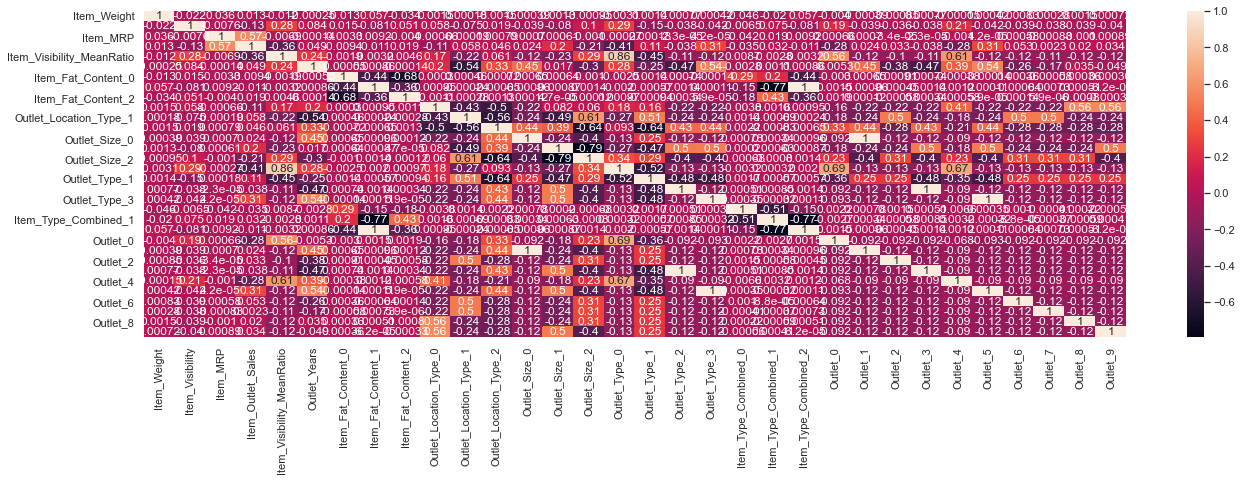

In [25]:
plt.figure(figsize = (22,6))
sns.heatmap(data.corr(), annot =True)

In [26]:
# get correlations
df_corr = data.corr()
df = pd.DataFrame(df_corr['Item_Outlet_Sales'])
df

,Item_Outlet_Sales
Item_Weight,0.013261
Item_Visibility,-0.128453
Item_MRP,0.567574
Item_Outlet_Sales,1.000000
Item_Visibility_MeanRatio,-0.356774
Outlet_Years,0.049135
Item_Fat_Content_0,-0.009438
Item_Fat_Content_1,-0.010861
Item_Fat_Content_2,0.018719
Outlet_Location_Type_0,-0.111287


In [27]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Visibility_MeanRatio,Outlet_Years,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Location_Type_0,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
count,14204.000000,14204.000000,14204.000000,8523.000000,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000,...,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000,14204.000000
mean,12.793380,0.069710,141.004977,2181.288914,1.061884,23.169319,0.457547,0.189102,0.353351,0.280203,...,0.065123,0.109335,0.108631,0.108843,0.061954,0.109758,0.109124,0.108983,0.109124,0.109124
std,4.651716,0.049728,62.086938,1706.499616,0.235907,8.371664,0.498212,0.391603,0.478027,0.449114,...,0.246751,0.312071,0.311187,0.311453,0.241081,0.312599,0.311806,0.311629,0.311806,0.311806
min,4.555000,0.003575,31.290000,33.290000,0.844563,12.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.710000,0.031145,94.012000,834.247400,0.925131,17.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.600000,0.057194,142.247000,1794.331000,0.999070,22.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16.750000,0.096930,185.855600,3101.296400,1.042007,34.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,21.350000,0.328391,266.888400,13086.964800,3.010094,36.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Multicollinearity

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# most correlated numerical cols with Class
variables = data[['Item_Visibility', 'Item_MRP', 'Item_Visibility_MeanRatio', 'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Type_0',  'Outlet_5']]
vif = pd.DataFrame()
vif["Features"] = variables.columns
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif.sort_values(by=['VIF'])

,Features,VIF
6,Outlet_5,1.503589
5,Outlet_Type_0,1.862478
0,Item_Visibility,3.224963
3,Outlet_Size_1,4.170775
1,Item_MRP,5.733223
4,Outlet_Size_2,5.883614
2,Item_Visibility_MeanRatio,16.098738


In [29]:
#Divide into test and train:
datacopy = data [['Item_Identifier','Outlet_Identifier', 'Item_Visibility', 'Item_MRP', 'Item_Visibility_MeanRatio', 'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Type_0',  'Outlet_5', 'source', 'Item_Outlet_Sales']]
train = datacopy.loc[data['source']=="train"]
test = datacopy.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'], axis=1,inplace=True)


#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

C:\Users\Mahira\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Model Building

In [30]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

In [31]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20)
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : ", np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ("CV Score : Mean - ", np.mean(cv_score), "| Std - ", np.std(cv_score), " | Min - ",np.min(cv_score), " | Max - " ,np.max(cv_score))
    
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

In [32]:
import warnings
warnings.filterwarnings('ignore')

# Linear Regression model


Model Report
RMSE :  1132.4430028655183
CV Score : Mean -  0.745553216876615 | Std -  0.018903090677680517  | Min -  0.6993114764894359  | Max -  0.7818278130787413


<AxesSubplot:title={'center':'Model Coefficients'}>

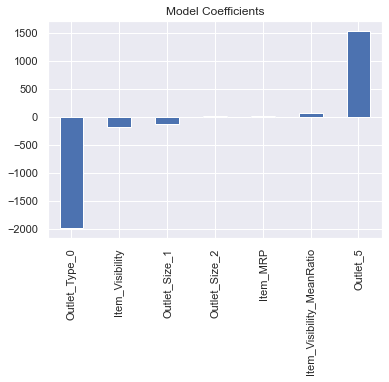

In [33]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

# Random Forest Regression


Model Report
RMSE :  1075.066296753003
CV Score : Mean -  0.7697084078000975 | Std -  0.02153587811523334  | Min -  0.7243408898313649  | Max -  0.8042361419551736


<AxesSubplot:title={'center':'Feature Importances'}>

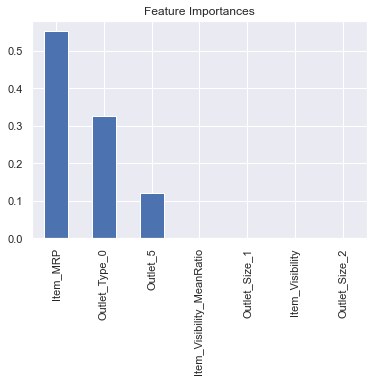

In [34]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

# XGBoost

In [44]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(learning_rate = .1)
modelfit(xgb_reg, train, test, predictors, target, IDcol, 'xgboost.csv')


Model Report
RMSE :  918.2249844892658
CV Score : Mean -  0.7577092826199179 | Std -  0.024119405359323356  | Min -  0.7125241198735737  | Max -  0.8041452463749462


# Support Vector model

In [36]:
from sklearn.svm import SVR
regsv = SVR(kernel = "rbf", C = 1e3, gamma = 1e-8, epsilon = 0.1 )
modelfit(regsv, train, test, predictors, target, IDcol, 'svreg.csv')


Model Report
RMSE :  1607.6866750075892
CV Score : Mean -  0.32481891199907337 | Std -  0.02340176201944914  | Min -  0.2852544650461791  | Max -  0.3704085698123379
